# Employment Analysis - Theme 1 & 5

By Paul Duckworth 23rd Aug 2018.

##### Employment Figures - Theme 5


- We have employment numbers from from NHS Digital, so we can produce a lasanga plot of risk affected employment

- assuming a uniform distribution over tasks (within an occupation). 

In [427]:
# encoding=utf8
import os
import numpy as np
import pandas as pd
import getpass
import pickle
import string
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family': 'serif', 'serif':"Computer Modern Roman"})
rc('text', usetex=True)
%matplotlib inline

## Output file:
out_file_path = "/home/scpd/Dropbox/Documents/Oxford/writing/FutureOfHealthcare_project_docs/FinalReports/Analysis_images/"

## # Input DATA set of observed Occupations and Tasks
datasets = '/home/'+ getpass.getuser() +'/Datasets/'
d = os.path.join(datasets, 'FoHealthcare/Final_dataset_27082018.xlsx')

excel_doc = pd.ExcelFile(d)
data = excel_doc.parse(sheet_name="ExpandedTasks")
data = data[data["clinical"] != 1]  # REMOVE CLINICAL TASKS

print(data.shape)
data.drop(columns="structured_work", inplace=True)
print(data["Observed Occupation"].unique())   # All  occupation, clerical tasks only

occupation_n_tasks = pd.DataFrame(data.groupby('Observed Occupation')['Task'].nunique().reset_index())
occupation_n_tasks.sort_values(by="Task", inplace=True, ascending=False)
occupation_n_tasks = occupation_n_tasks.reset_index(drop=True)
occupation_n_tasks.head()

(264, 23)
['Administrator' 'Deputy Practice Manager' 'General Practitioner'
 'Healthcare Assistant' 'Nurse Practitioner' 'Pharmacy Technician'
 'Phlebotomist' 'Practice Manager' 'Practice Nurse' 'Practice Pharmacist'
 'Prescription Clerk' 'Receptionist' 'Scanning Clerk' 'Secretary'
 'Summariser']


,Observed Occupation,Task
0,Administrator,40
1,Receptionist,38
2,Practice Manager,37
3,Deputy Practice Manager,33
4,Secretary,23


## Plot just clerical worker barh plot

In [428]:
# # RESTRICT TO CLERICAL WORKERS
unique_occupations = data["Observed Occupation"].unique()
clinical_occupations = ['General Practitioner', 'Healthcare Assistant', 'Nurse Practitioner', 'Phlebotomist', 'Practice Nurse']
clerical_occupations = [i for i in unique_occupations if i not in clinical_occupations]

occupation_n_tasks_clerical = occupation_n_tasks[occupation_n_tasks["Observed Occupation"].isin(clerical_occupations)]
occupation_n_tasks_clinical = occupation_n_tasks[occupation_n_tasks["Observed Occupation"].isin(clinical_occupations)]

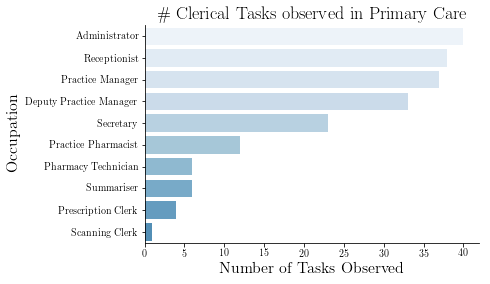

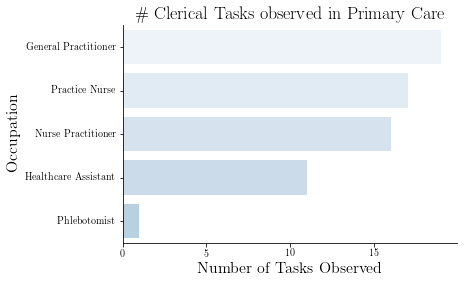

In [429]:
# color =   ['#c693bf','#73d758','#cdd152','#624db8','#628c41','#c54680','#80d3b3','#d44c3d',\
# '#6f9dc3','#c4853a','#462f55','#cbb394','#793f36','#42543c']
# palette = itertools.cycle(color)

for df, name in zip([occupation_n_tasks_clerical, occupation_n_tasks_clinical], ["clerical", "clinical"]):

    plt.cla
    fig, ax = plt.subplots()
    ax.tick_params(top='off', bottom='on', left='on', right='off', labelleft='on', labelbottom='on')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([0,5,10,15,20,25,30,35,40])
    ax.set_title("\# Clerical Tasks observed in Primary Care", fontsize=18)
    ax = sns.barplot(y='Observed Occupation', x="Task", data=df, palette=sns.color_palette("Blues",15)) # palette=palette)#, 
    ax.set_ylabel("Occupation", fontsize=16)
    ax.set_xlabel("Number of Tasks Observed", fontsize=16)

    fig.savefig(out_file_path + "histogram_of_tasks_%s.pdf" % name, bbox_inches='tight')
    fig.savefig(out_file_path + "histogram_of_tasks_%s.png" % name, bbox_inches='tight')

## Present a barh plot of automatable "risk" categories

In [430]:
 # # Add risk categories to the data:
data_clerical = data[data["Observed Occupation"].isin(clerical_occupations)]
cats = {1: 'Not Automatable', 2: 'Partly Automatable', 3: 'Automatable'}
data_clerical = data_clerical.assign(risk_catn = lambda x: np.floor(x['Weighted Average Automation Score']))
data_clerical['risk_cat'] = data_clerical['risk_catn'].map(cats)

In [431]:
occupation_n_tasks_by_cat = pd.DataFrame(data_clerical.groupby(['Observed Occupation','risk_cat','risk_catn'])['Task']\
                                         .nunique()\
                                         .reset_index())

occupation_n_tasks_clerical.rename(columns={"Task":"Sum"}, inplace=True)
figure_9_data = occupation_n_tasks_by_cat.merge(occupation_n_tasks_clerical, on='Observed Occupation', how='left')
figure_9_data["percentage"] = figure_9_data["Task"] / figure_9_data["Sum"]*100
figure_9_data.head()

/home/scpd/Software/anaconda3/envs/env3.5/lib/python3.5/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Observed Occupation,risk_cat,risk_catn,Task,Sum,percentage
0,Administrator,Automatable,3.0,23,40,57.500000
1,Administrator,Not Automatable,1.0,1,40,2.500000
2,Administrator,Partly Automatable,2.0,16,40,40.000000
3,Deputy Practice Manager,Automatable,3.0,11,33,33.333333
4,Deputy Practice Manager,Not Automatable,1.0,1,33,3.030303


In [432]:
def barh_sorted(df, by, column, rot=0, vert=False):
    
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    #sorts df2 by the median value.
    meds = df2.median().sort_values(ascending=False)
    return df2[meds.index].boxplot(rot=rot, grid=False, return_type="axes", vert=vert)


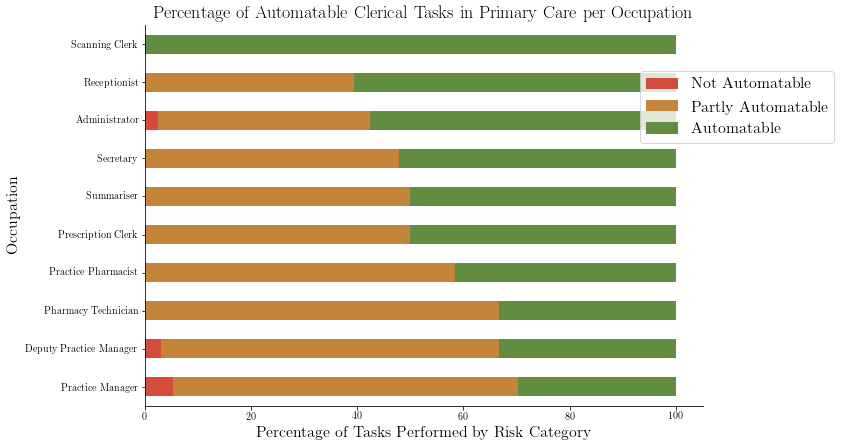

In [433]:
pivot_df = figure_9_data.pivot(index='Observed Occupation', columns='risk_cat', values='percentage')
color = ['#d44c3d','#c4853a','#628c41']

ax = pivot_df.sort_values(by="Automatable", ascending=True)\
             .loc[:,['Not Automatable', 'Partly Automatable', 'Automatable']]\
             .plot.barh( stacked=True, color=color, figsize=(10,7), )

ax.tick_params(top='off', bottom='on', left='on', right='off', labelleft='on', labelbottom='on')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel("Occupation", fontsize=16)
ax.set_xlabel("Percentage of Tasks Performed by Risk Category", fontsize=16)
ax.set_title("Percentage of Automatable Clerical Tasks in Primary Care per Occupation", fontsize=18)
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 0.9), fontsize=16)

savename = "occupation_bars"
plt.savefig(out_file_path+"{}.pdf".format(savename), format="pdf", bbox_inches='tight')
plt.savefig(out_file_path+"{}.png".format(savename), format="png", bbox_inches='tight')


## List all unique tasks and their score - to check for inconsistancies

In [434]:
sorted_task_scores = \
    data_clerical[["Task", "DWA Task", "DWA ID", "Automation Scores", "Weighted Average Automation Score"]]\
    .sort_values(by="Weighted Average Automation Score")
sorted_task_scores.head() #.to_excel(os.path.join(datasets, 'FoHealthcare/sorted_task_scores.xlsx'))

,Task,DWA Task,DWA ID,Automation Scores,Weighted Average Automation Score
60,Staff recruitment,Recruit personnel.,4.A.4.c.2.I01.D05,1.65;,1.653846
27,Staff recruitment,Recruit personnel.,4.A.4.c.2.I01.D05,1.65;,1.653846
201,Staff recruitment,Recruit personnel.,4.A.4.c.2.I01.D05,1.65;,1.653846
181,Conducting training in-person,Conduct employee training programs.; Train emp...,4.A.4.b.3.I04.D16; 4.A.4.b.3.I04.D14,1.31; 2.25;,1.778846
190,Managing meeting diaries,Schedule activities or facility use.,4.A.2.b.5.I01.D04,2.07;,2.074248


## ## Use NHS DIgital Figures to compute Clerical workers "at risk"

- set up categories as Occupations.

In [435]:

# # NHS Digital Employment Figures
nhs_employment_figures = excel_doc.parse(sheet_name="employment_figures")
nhs_employment_figures["catn"] = nhs_employment_figures.index

categories = nhs_employment_figures[["catn","Observed Occupation"]]
categories = categories[categories["Observed Occupation"].isin(clerical_occupations)]
categories.head()

,catn,Observed Occupation
0,0,Administrator
1,1,Deputy Practice Manager
5,5,Pharmacy Technician
7,7,Practice Manager
9,9,Practice Pharmacist


In [437]:
# catn is used for occupation category number now
lasagna_data = data_clerical.merge(nhs_employment_figures, on="Observed Occupation")
lasagna_data.head()

,Observed Occupation,Task,Task keywords/context,GP Code,DWA Task,DWA ID,Notes,Task also done by,Technology Use,Technology use3,...,clinical,Task Weight,Automation Scores,Weighted Average Automation Score,risk_catn,risk_cat,December 2017,n_tasks,Employment,catn
0,Administrator,Address problems that arise with building,NaN,BSC,"Notify others of emergencies, problems, or haz...",4.A.4.a.2.I08.D07; 4.A.4.a.2.I08.D04; 4.A.4.a....,NaN,Deputy Practice Manager; Administrator,NaN,NaN,...,0,0.20; 0.20; 0.20; 0.20; 0.20;,3.27; 2.90; 3.30; 3.10; 2.46;,3.004637,3.0,Automatable,64565,40,1614.125,0
1,Administrator,Answer phone,NaN,NaN,Answer telephones to direct calls or provide i...,4.A.4.a.3.I03.D11,NaN,Practice Nurse; Nurse Practitioner; Healthcare...,phone,desktop,...,0,1.00;,3.15;,3.153151,3.0,Automatable,64565,40,1614.125,0
2,Administrator,Checking for errors in paperwork,NaN,BSC,Check data for recording errors.,4.A.2.a.2.I01.D08,NaN,Administrator; Practice Manager; Secretary,desktop,paper forms,...,0,1.00;,3.27;,3.272835,3.0,Automatable,64565,40,1614.125,0
3,Administrator,Cleaning up information in the patients electr...,NaN,NaN,Process healthcare paperwork.,4.A.4.c.1.I01.D03,Summarisers do this while they are working wit...,Practice Nurse; Nurse Practitioner; Healthcare...,NaN,NaN,...,0,1.00;,2.91;,2.913987,2.0,Partly Automatable,64565,40,1614.125,0
4,Administrator,Connecting human resources/making introduction...,NaN,BSC,Relay information between personnel.,4.A.4.a.2.I03.D11,NaN,Deputy Practice Manager; Administrator,NaN,NaN,...,0,1.00;,3.38;,3.375000,3.0,Automatable,64565,40,1614.125,0


In [426]:
# subset = lasagna_data[lasagna_data["Observed Occupation"].str.contains("Practice")]

emp = 'Employment'
cat_n =  'catn'
cat_text = "Observed Occupation"
y = 'Weighted Average Automation Score'
title = "Automatability of Clerical work in Primary Care"

stacked_automation_plot(lasagna_data, categories, y, emp, cat_n, cat_text, [0.25,0.521,0.752], title)


category numbers:  [ 0  1  5  7  9 10 11 12 13 14]


KeyError: 'catn'

## Create a lasagna plot for Clinical vs Clerical major categories - REMOVED

In [ ]:
# clincal_categories = pd.DataFrame(data = {"clinical":["clerical", "clinical"], "catn": [0,1]})
# clincal_categories

In [93]:
# # # Theme 3 removed:

# struct_categories = pd.DataFrame(data = {"structured":["structured", "unstructured"], "catn": [1,-1]})
# struct_categories

# emp = 'Employment'
# cat_n =  'catn'
# cat_text = "structured"

# lasagna_data["catn"] = lasagna_data["structured"]
# lasagna_data = lasagna_data[lasagna_data["catn"].isin([1,-1])]

# y = 'Weighted Average Automation Score'
# title = "Task Automatability grouped by type of work"

# stacked_automation_plot(lasagna_data, struct_categories, y, emp, cat_n, cat_text, [0.25,0.521,0.752], title, "struct")


In [287]:
# # Lasagna Plot
# # Mike's code which includes a CDF and fancy text and arrows on the graph.
import seaborn as sns
import itertools
import matplotlib.patches as mpatches
import os

probability_thresholds = [1., 2., 3., 4.]
risk_names = ['Low', 'Med', 'High']

percent_risk_names = [
    r + ' probability of automation percent'
    for r in risk_names
]

def stacked_automation_plot(
    country_data,
    categories=pd.DataFrame({'category_number': 0, 'category_name': 'default'}, index=[0]),
    probability_column='Probability of automation',
    employment_column='# of employed individuals',
    category_number_col='category_number',
    category_column='category',
    prob_locs = [1,2,3,4],
    figure_title = "",
    sub=""    
):
    """
    Make stacked plot of the automatability of a country's employment

    Parameters
    ----------
    country_data : DataFrame
    categories : DataFrame
    prob_locs : List of text x locations

    Returns
    -------
    """

    
    # Define units of employment (e.g. thousands or millions)
    units = 1e1
    units_name = ""
    num_prob_bins = 150

    prob_bins = np.linspace(1, 4, num_prob_bins)
    window_size = round(num_prob_bins/20)

    num_categories = len(categories)
    is_categorised = num_categories > 1

    employment = np.empty([num_categories, num_prob_bins])

    print("category numbers: ", categories[category_number_col].values)
    
    for category_ix, category in enumerate(categories[category_number_col].values):
        for prob_ix in range(num_prob_bins):
            
#             print(type(country_data[category_column]),type(category))
            if is_categorised:
                category_mask = (country_data[category_number_col] == category)
            else:
                # a hack to select all data
                category_mask = (country_data[probability_column] >= 0)

            category_probs = (country_data[probability_column][category_mask])

            category_employment = (
                country_data[employment_column][category_mask] / units)

            lower_lim = int(max(1, prob_ix - window_size))
            upper_lim = int(min(num_prob_bins - 4, prob_ix + window_size))

            in_bin_mask = (
                (category_probs > prob_bins[lower_lim])
                & (category_probs < prob_bins[upper_lim]) )

            employment[category_ix, prob_ix] = (
                sum(category_employment[in_bin_mask])
                / ((upper_lim - lower_lim) / float(num_prob_bins)) )

    fig, ax = plt.subplots()   
   
#   color =   ['#c693bf','#73d758','#b849cc','#cdd152','#624db8','#628c41','#c54680','#80d3b3','#d44c3d',\
#     '#6f9dc3','#c4853a','#462f55','#cbb394','#793f36','#42543c']

    color =   ['#c693bf','#73d758', '#cdd152','#624db8','#628c41','#80d3b3','#d44c3d',\
'#cbb394','#c4853a','#462f55']
    
    palette = itertools.cycle(color)
    
    ax.stackplot(prob_bins, employment, colors=color)
    ax.set_ylabel('Total Employment' + units_name, fontsize=16)
    ax.set_xlabel('Automatability Score', fontsize=14)
      
# Not sure what this bit does (if anything):
#     if is_categorised:
#         plot_data_content = {
#             str(category) + ' employment': employment[category_ix, :]
#             for category_ix, category in enumerate(categories[category_number_col].values) }

#     else:
#         plot_data_content = {'employment': employment[0, :]}

#     plot_data_content.update({'probability bins': prob_bins})
#     plot_data = pd.DataFrame(plot_data_content)

    country_summary = find_high_med_low_probability_fractions(
        country_data,
        probability_column=probability_column,
        employment_column=employment_column
    )

    for i_prob in range(len(probability_thresholds)-1):

        field = percent_risk_names[i_prob]
        descriptive_text = (
#             u"←  " + "{0:.0f}".format(country_summary[field].values[0]) + u"\%  →\n"
             "$\Leftarrow$   {0:.0f}\%  $\Rightarrow$".format(country_summary[field].values[0]) 
        )
        plt.text(
            prob_locs[i_prob],
#             np.mean(probability_thresholds[i_prob:i_prob+2]) / 4.0,
            0.95,
            descriptive_text,
            transform=ax.transAxes,
            horizontalalignment='center',
            verticalalignment='top',
            bbox={'facecolor': 'none', 'edgecolor': 'none', 'pad': 2}
        )

    ax.plot([2, 2], [0, 1 * ax.get_ylim()[1]], '--', linewidth=1.,color='k')    
    ax.plot([3, 3], [0, 1 * ax.get_ylim()[1]], '--', linewidth=1.,color='k')
    
    category_names = categories[category_column].values.tolist();       
    ax.set_xticks([1., 2., 3., 4.])
    ax.set_xticklabels(['1\nNot at All\nAutomatable',
                    '2\nMostly Not\nAutomatable',
                    '3\nMostly\nAutomatable',
                    '4\nCompletely\nAutomatable'], fontsize=14)

    leg = ax.legend(
        [mpatches.Patch(color=next(palette))
            for i in range(len(category_names))],
        category_names,
        ncol=2, prop={'size': 14},
        bbox_to_anchor=(0,-0.5,1,0.2),
        loc="upper left", fontsize=20)
    leg.get_frame().set_linewidth(0.0)
   
    ax.tick_params(top='off', bottom='on', left='off', right='off', labelleft='off', labelbottom='on')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)    
    ax.set_title(figure_title, fontsize=18)
    
    out_file_path = "/home/scpd/Dropbox/Documents/Oxford/writing/FutureOfHealthcare_project_docs/FinalReports/Analysis_images/"
    name = 'employment_effected' 
    fig.savefig(out_file_path+name+".pdf", bbox_inches="tight")
    fig.savefig(out_file_path+name+".png", bbox_inches="tight")

    return country_summary


def find_high_med_low_probability_fractions(
    country_data,
    probability_column='Probability of automation',
    employment_column='# of employed individuals'
):

    """
    Compute the fractions of this country's employment in high, medium and low
    probability of automation categories.

    Parameters
    ----------
    country_data : DataFrame


    Returns
    -------
    country_summary : DataFrame

    """

    employment_risk_names = [
        r + ' probability of automation employment'
        for r in risk_names
    ]
    country_total_employment = country_data[employment_column].sum()
    
    # Initialise empty-ish DataFrame
    risk_columns = percent_risk_names + employment_risk_names
    country_summary_content = dict({
        s: np.nan
        for s in risk_columns
    })
    country_summary_content['total_employment'] = country_total_employment
    country_summary = pd.DataFrame(
        country_summary_content,
        index=[0]
    )

    for i_prob in range(len(probability_thresholds)-1):
        lo_prob = probability_thresholds[i_prob]
        hi_prob = probability_thresholds[i_prob + 1]
        
        in_range_data = country_data.ix[
            (country_data[probability_column] > lo_prob)
            &
            (country_data[probability_column] <= hi_prob)
        ]

        in_range_employment = in_range_data[
            employment_column
        ].sum()
        country_summary[
            employment_risk_names[i_prob]
        ] = in_range_employment
        
        country_summary[
            percent_risk_names[i_prob]
        ] = 100 * in_range_employment / float(country_total_employment)

    # reorder columns
    columns = risk_columns + ['total_employment']
    country_summary = country_summary[columns]
    return country_summary
